In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

import numpy as np
from qaoa import *
from exactcover import *

#from classical_exactcover_solver import *
import os

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *
from data.tailassignment_loader import * 
from tqdm import tqdm # progress bar

from qiskit.visualization import plot_histogram

In [3]:
from tailassignment_oop import *

In [4]:
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

fontsize = 24
newparams = {'axes.titlesize': fontsize,
             'axes.labelsize': fontsize,
             'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 
             'legend.fontsize': fontsize,
             'figure.titlesize': fontsize,
             'legend.handlelength': 1.5, 
             'lines.linewidth': 2,
             'lines.markersize': 7,
             'figure.figsize': (12, 7), 
             'figure.dpi':200,
             'text.usetex' : True,
             'font.family' : "sans-serif"
            }

plt.rcParams.update(newparams)

In [5]:
instances = 4
flights   = 3
solutions = 2

path_to_examples = "../data/tailassignment_samples/"

FR, CR, best_sol = load_FR_CR(path_to_examples + f'FRCR_{instances}_{flights}_{solutions}.txt')

# Using big weights does not work for some reason

CR /= np.max(CR)
mu  = 1

# Best solution 
best_key  = "".join([str(i) for i in best_sol])[::-1]
best_cost = CR @ best_sol

In [6]:
options={}
options['FR'] = FR
options['CR'] = CR
options['mu'] = 1 
options['usebarrier'] = True

beta_n    = 20
gamma_n   = 40

beta_max  = np.pi
gamma_max = 2 * np.pi

optmethod = 'Nelder-Mead'        
# shots     = 1024 # no need for shots when using statevector simulator
rerun     = True
max_depth  = 6

In [7]:
Aer.backends()
backend = Aer.get_backend('statevector_simulator')

In [8]:
simulation_args = dict()

simulation_args['backend']   = backend
simulation_args['optmethod'] = optmethod
simulation_args['max_depth'] = max_depth
simulation_args['repeats']   = 1
simulation_args['params_ll'] = np.array([0,0])
simulation_args['params_ul'] = np.array([gamma_max,beta_max])
simulation_args['params_n']  = np.array([gamma_n, beta_n])
#simulation_args['shots']     = shots

In [9]:
options

{'FR': array([[1., 0., 1., 0.],
        [1., 0., 0., 1.],
        [0., 1., 0., 0.]]),
 'CR': array([1. , 0.2, 0.2, 0.2]),
 'mu': 1,
 'usebarrier': True}

In [10]:
simulation_args

{'backend': StatevectorSimulator('statevector_simulator'),
 'optmethod': 'Nelder-Mead',
 'max_depth': 6,
 'repeats': 1,
 'params_ll': array([0, 0]),
 'params_ul': array([6.28318531, 3.14159265]),
 'params_n': array([40, 20])}

## Plain QAOA 

In [11]:
qaoa = QAOATailAssignment(options)

In [12]:
Elandscape, gammabetas, E, best = qaoa.simulate(**simulation_args)

Calculating energy landscape ...
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 1.274616
         Iterations: 12
         Function evaluations: 25
P = [4.63693086 2.08222408]
P_ = [4.63693086 2.08222408 4.63693086 2.08222408]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 0.825644
         Iterations: 103
         Function evaluations: 178
P = [5.21564194 0.68800555 4.65967747 1.13229415]
P_ = [5.21564194 0.68800555 4.9376597  0.91014985 4.65967747 1.13229415]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 0.634388
         Iterations: 758
         Function evaluations: 1157
P = [ 0.88308603  1.66436249 11.05318715  0.53304712  1.83559113  0.36774109]
P_ = [0.88308603 1.66436249 7.66315344 0.91015224 7.98065514 0.47794511
 1.83559113 0.36774109]
Depth = 4, Rep = 1
P = [ 1.5385118   1.7689693  11.62115802  2.32698721  6.53211

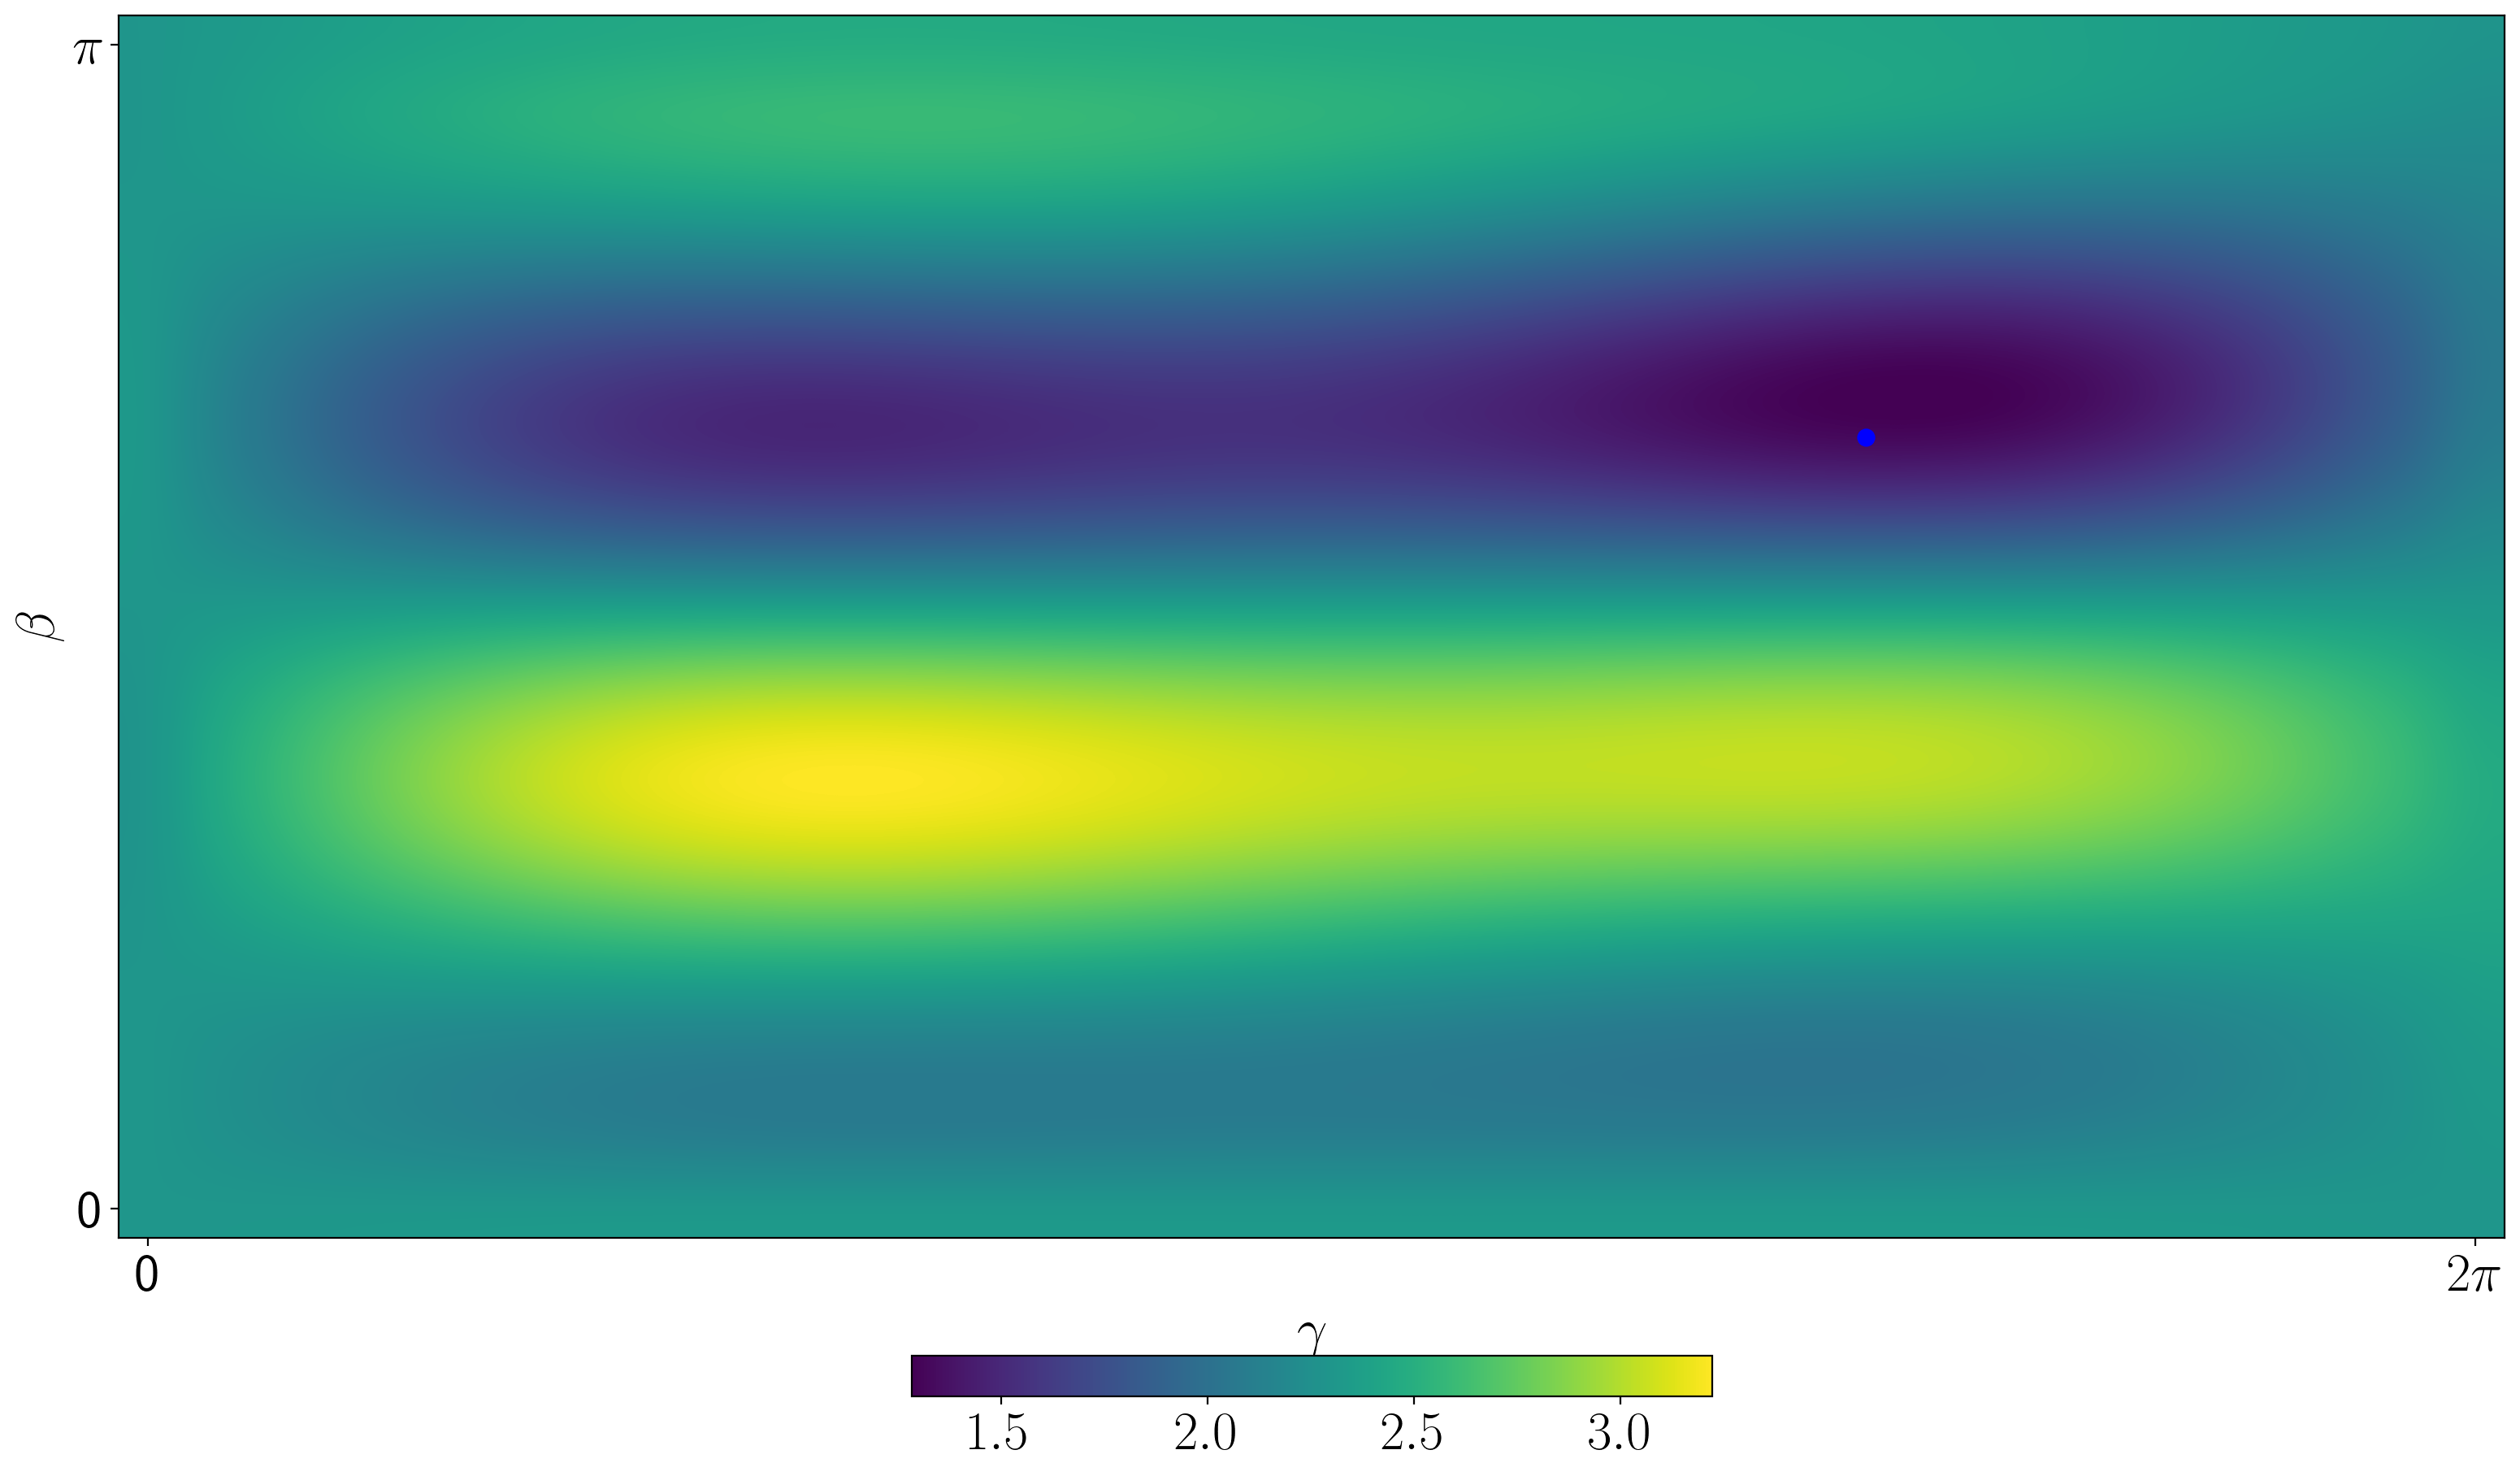

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

shiftg=gamma_max/(2*gamma_n)
shiftb=beta_max/(2*beta_n)

fig = plt.figure(figsize=(20,10));
plt.clf()
plt.imshow(Elandscape,
          interpolation='spline36',
          origin='lower',
          extent=[-shiftg,gamma_max+shiftg,-shiftb,beta_max+shiftb], 
          aspect=1)

plt.xticks([0,gamma_max], ['0', r'$2\pi$'])
plt.yticks([0,beta_max], ['0', r'$\pi$'])
plt.xlabel('$\gamma$',loc='center')
plt.ylabel(r'$\beta$',loc='center')

plt.colorbar(shrink=0.25, pad=0.075, orientation="horizontal")
plt.plot(gammabetas['xL_d1'][0], gammabetas['xL_d1'][1],'ob')

# plot all gamma-and beta values for each layer in the same plot
# Note that the energy landscape is high dimensional and thus this may not necessarily  
# be linked to the landscape 

cmap = plt.get_cmap('bwr')

#for d in range(maxdepth):
#    plt.plot(gammabetas[f'xL_d{d+1}'][0], gammabetas[f'xL_d{d+1}'][1],marker = "o", color = cmap(d/maxdepth))
    
plt.tight_layout()

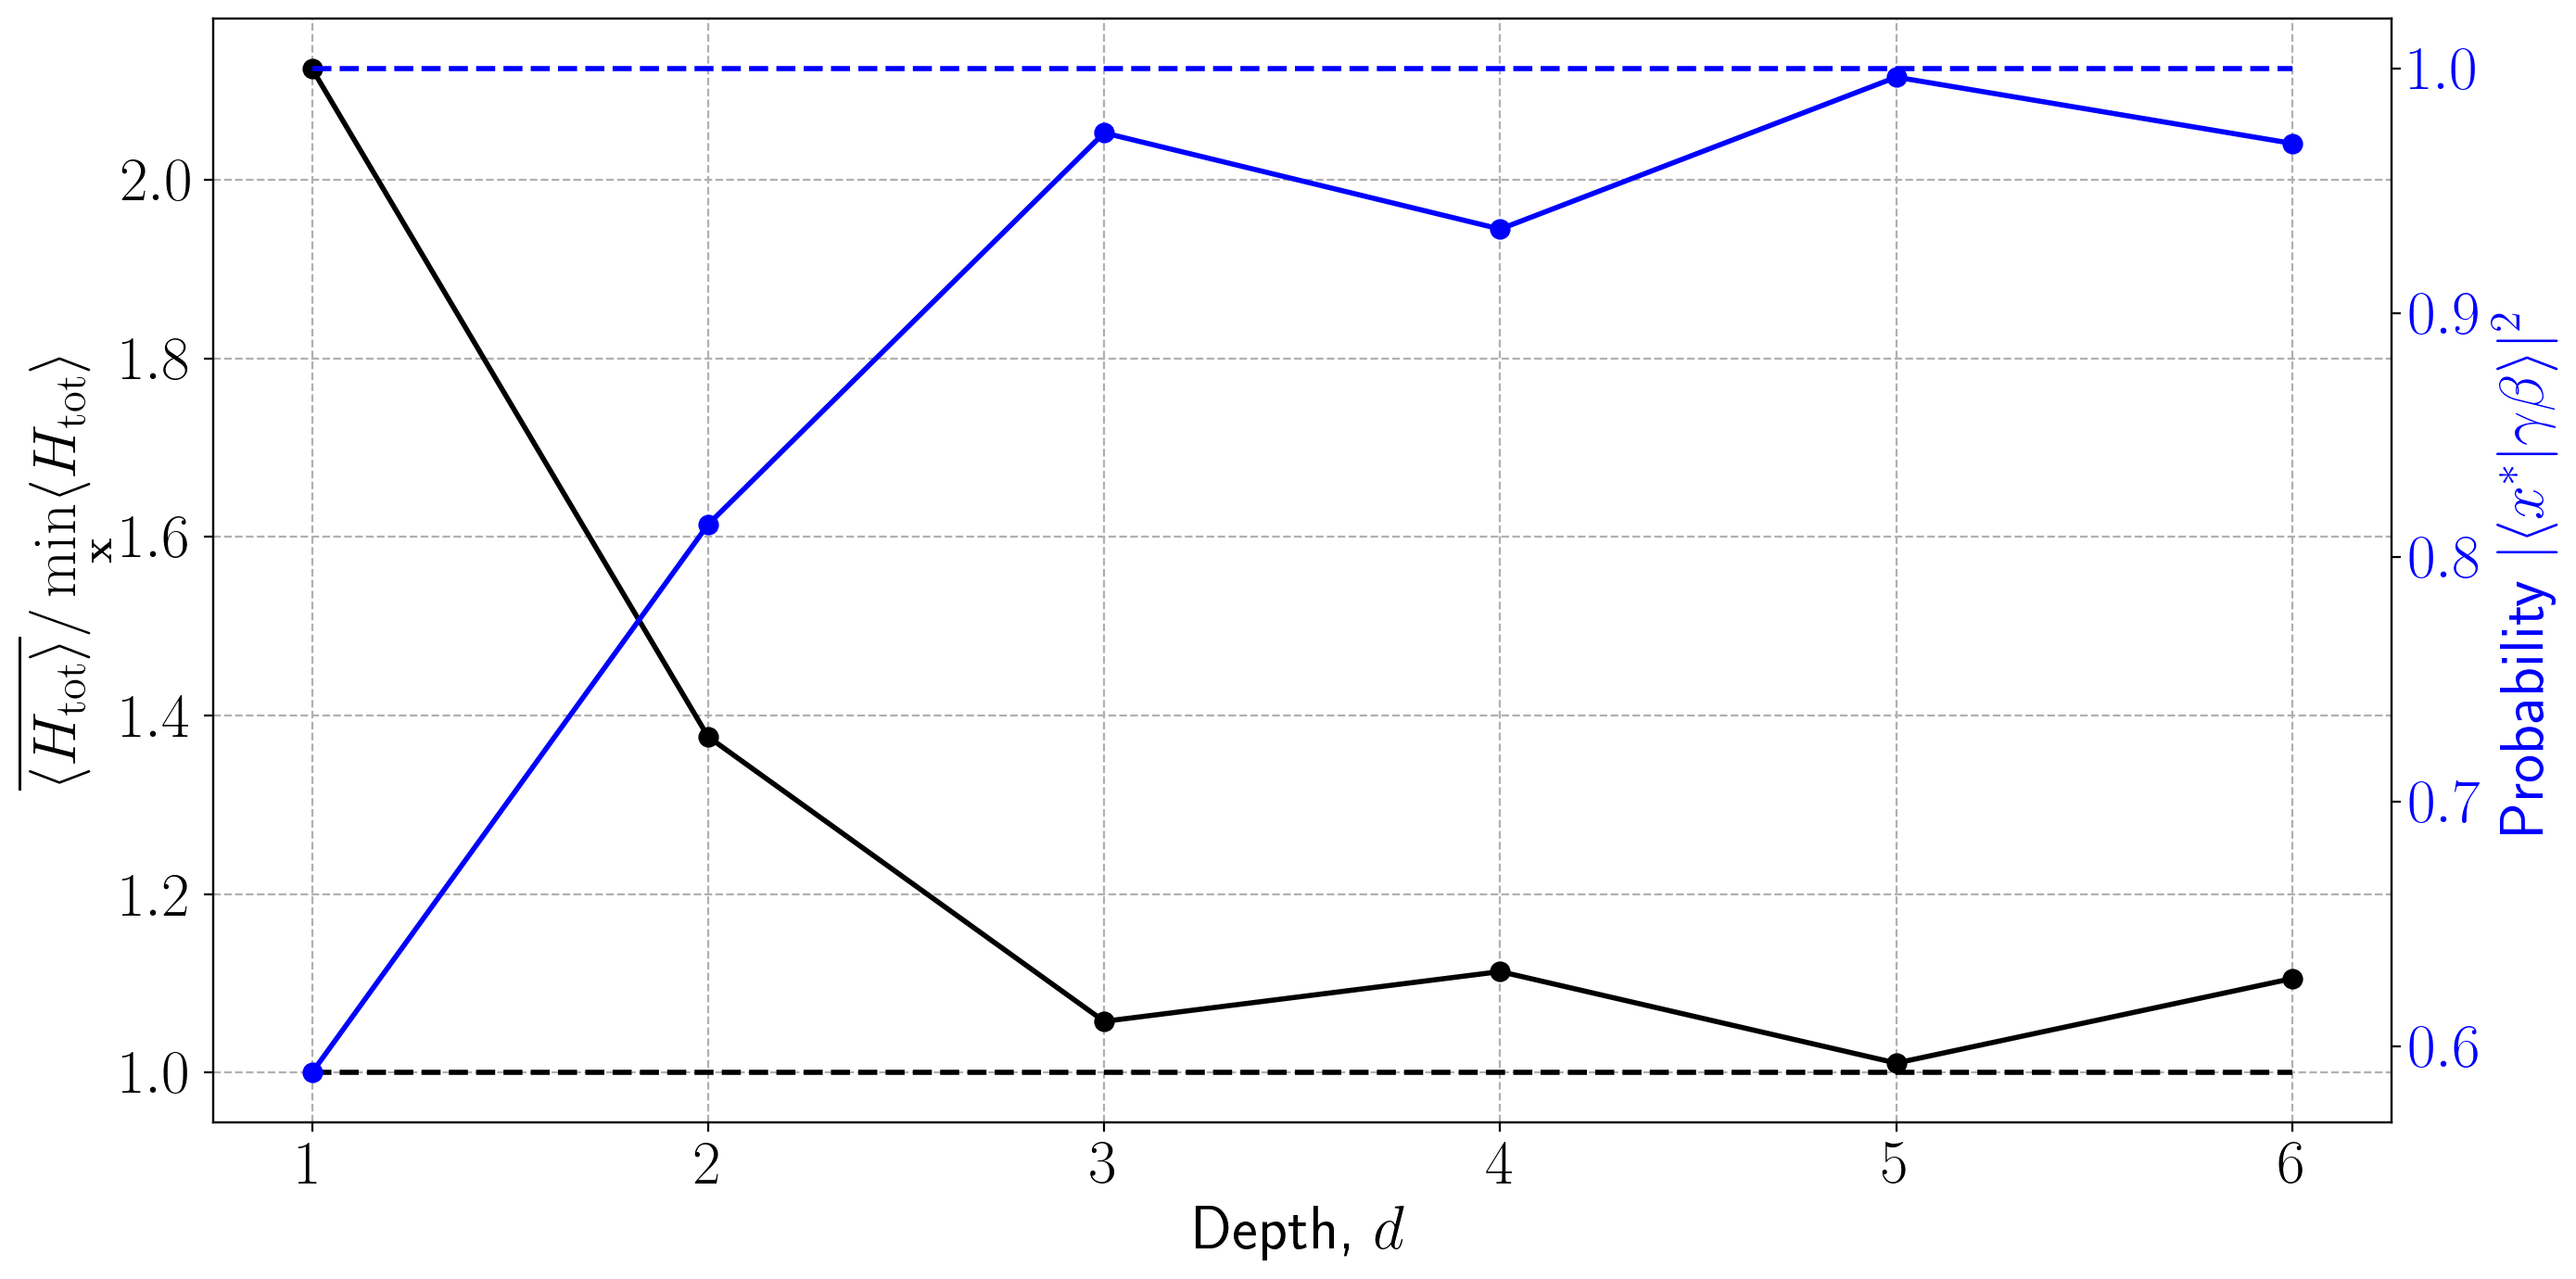

(array([0.58914725, 0.81347256, 0.97374979, 0.93436368, 0.99655575,
        0.9694273 ]),
 array([-1.27461561, -0.82564369, -0.63438787, -0.66783713, -0.60634294,
        -0.66317525]))

In [14]:
qaoa.simulation_statistics(plot = True)

## Separated discretization

In [11]:
qaoa_separated_disc = TailAssignmentSepDisc(options)

In [12]:
qaoa_separated_disc.simulate(**simulation_args);

Calculating energy landscape ...
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 0.516113
         Iterations: 11
         Function evaluations: 23
P = [2.34503562 2.02006653]
P_ = [2.34503562 2.02006653 2.34503562 2.02006653]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 112
         Function evaluations: 191
Calculating energy landscape ...
Calculating energy landscape done.
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 2.114488
         Iterations: 15
         Function evaluations: 31
P = [7.58296247 2.05949292]
P_ = [7.58296247 2.05949292 7.58296247 2.05949292]
Depth = 4, Rep = 1
Optimization terminated successfully.
         Current function value: 0.969145
         Iterations: 162
         Function evaluations: 270
P = [0.18920592 2.38134659 5.48644609 2.18980965]
P_ = [0.18920592 2.38134

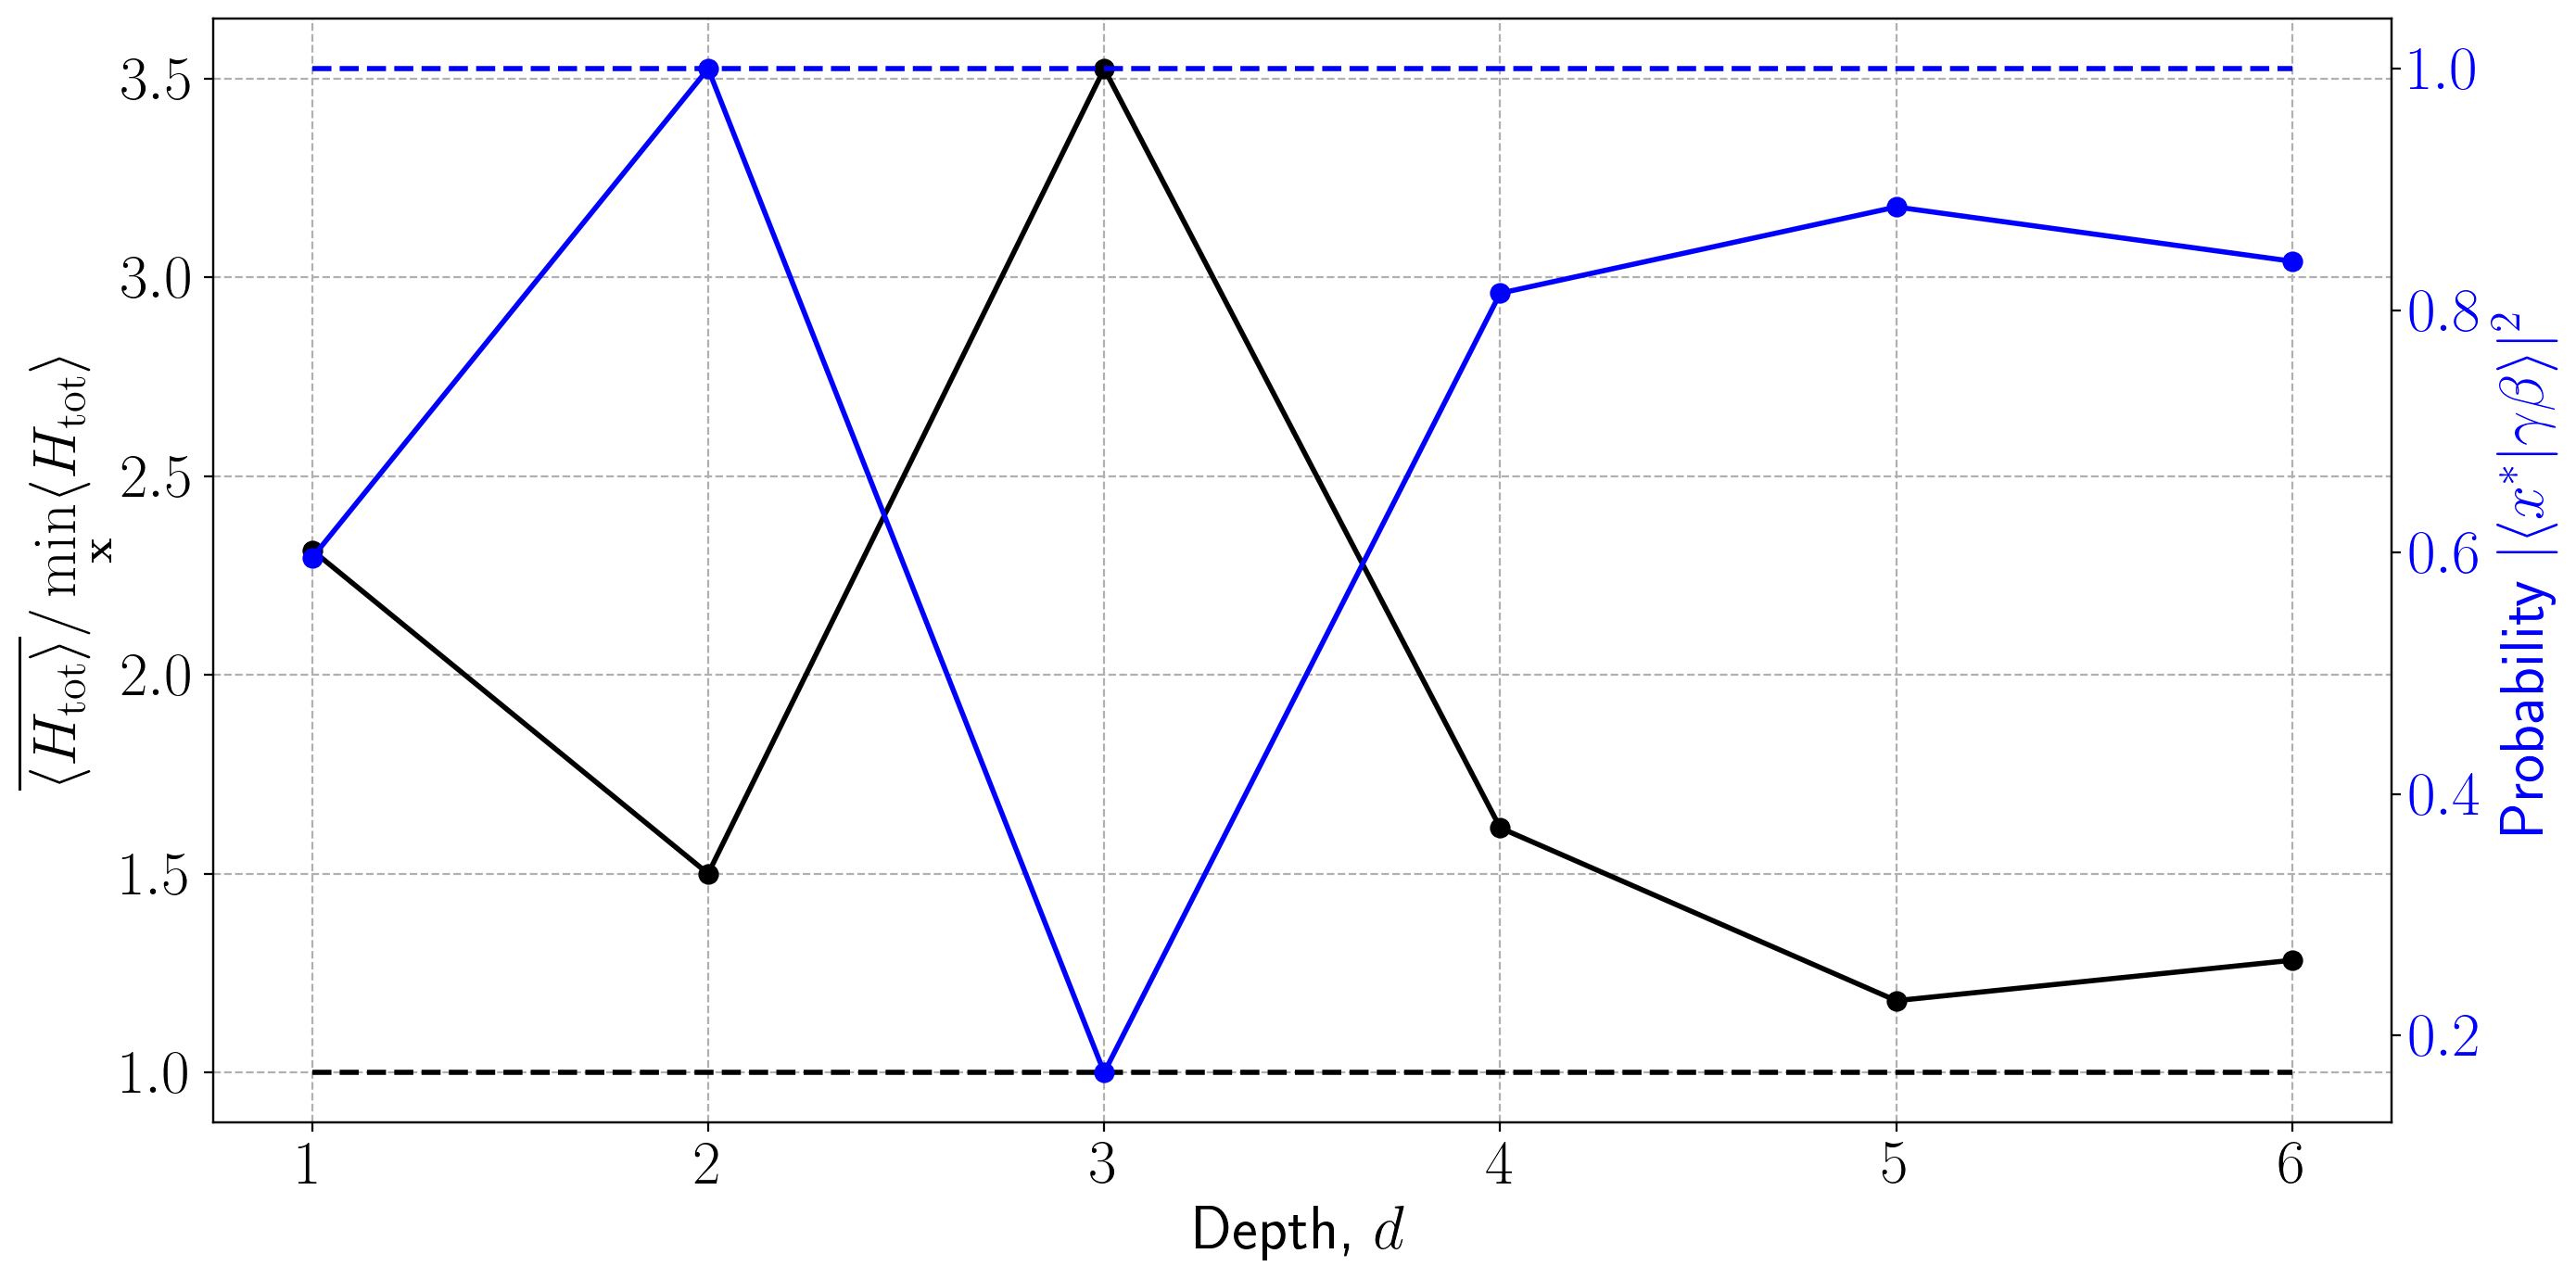

In [13]:
SP, C = qaoa_separated_disc.simulation_statistics(plot = True);

## Interlaced discretization

In [14]:
options={}
options['FR'] = FR
options['CR'] = CR
options['mu'] = 1 
options['usebarrier'] = True

beta_n    = 10
gamma_n   = 10
delta_n   = 10

beta_max  = np.pi
gamma_max = 2 * np.pi
delta_max = 2 * np.pi

optmethod = 'Nelder-Mead'        
#shots     = 1024 # no need for shots when using the statevector simulation
rerun     = True
max_depth  = 6

In [15]:
simulation_args = dict()

simulation_args['backend']   = backend
simulation_args['optmethod'] = optmethod
simulation_args['max_depth'] = max_depth
simulation_args['repeats']   = 1
simulation_args['params_ll'] = np.array([0,0,0])
simulation_args['params_ul'] = np.array([gamma_max,beta_max,delta_max])
simulation_args['params_n']  = np.array([gamma_n, beta_n, delta_n])
#simulation_args['shots']     = shots

In [16]:
qaoa3param = TailAssignmentInterlaced(options)

In [17]:
qaoa3param.simulate(**simulation_args);

Calculating energy landscape ...
Calculating energy landscape done.
Depth = 1, Rep = 1
Optimization terminated successfully.
         Current function value: 1.365817
         Iterations: 18
         Function evaluations: 34
P = [ 2.27744219  1.98994452 -0.77012173]
P_ = [ 2.27744219  1.98994452 -0.77012173  2.27744219  1.98994452 -0.77012173]
Depth = 2, Rep = 1
Optimization terminated successfully.
         Current function value: 0.938149
         Iterations: 228
         Function evaluations: 361
P = [ 1.90731182  1.78017818 -0.13736     3.24354404  1.88790795 -1.10840756]
P_ = [ 1.90731182  1.78017818 -0.13736     2.57542793  1.83404306 -0.62288378
  3.24354404  1.88790795 -1.10840756]
Depth = 3, Rep = 1
Optimization terminated successfully.
         Current function value: 0.895595
         Iterations: 321
         Function evaluations: 475
P = [ 0.96754207  1.99046486 -0.12208485  2.57817891  1.80842723 -0.73584181
  3.18275465  1.78573012 -1.5817201 ]
P_ = [ 0.96754207  1.990464

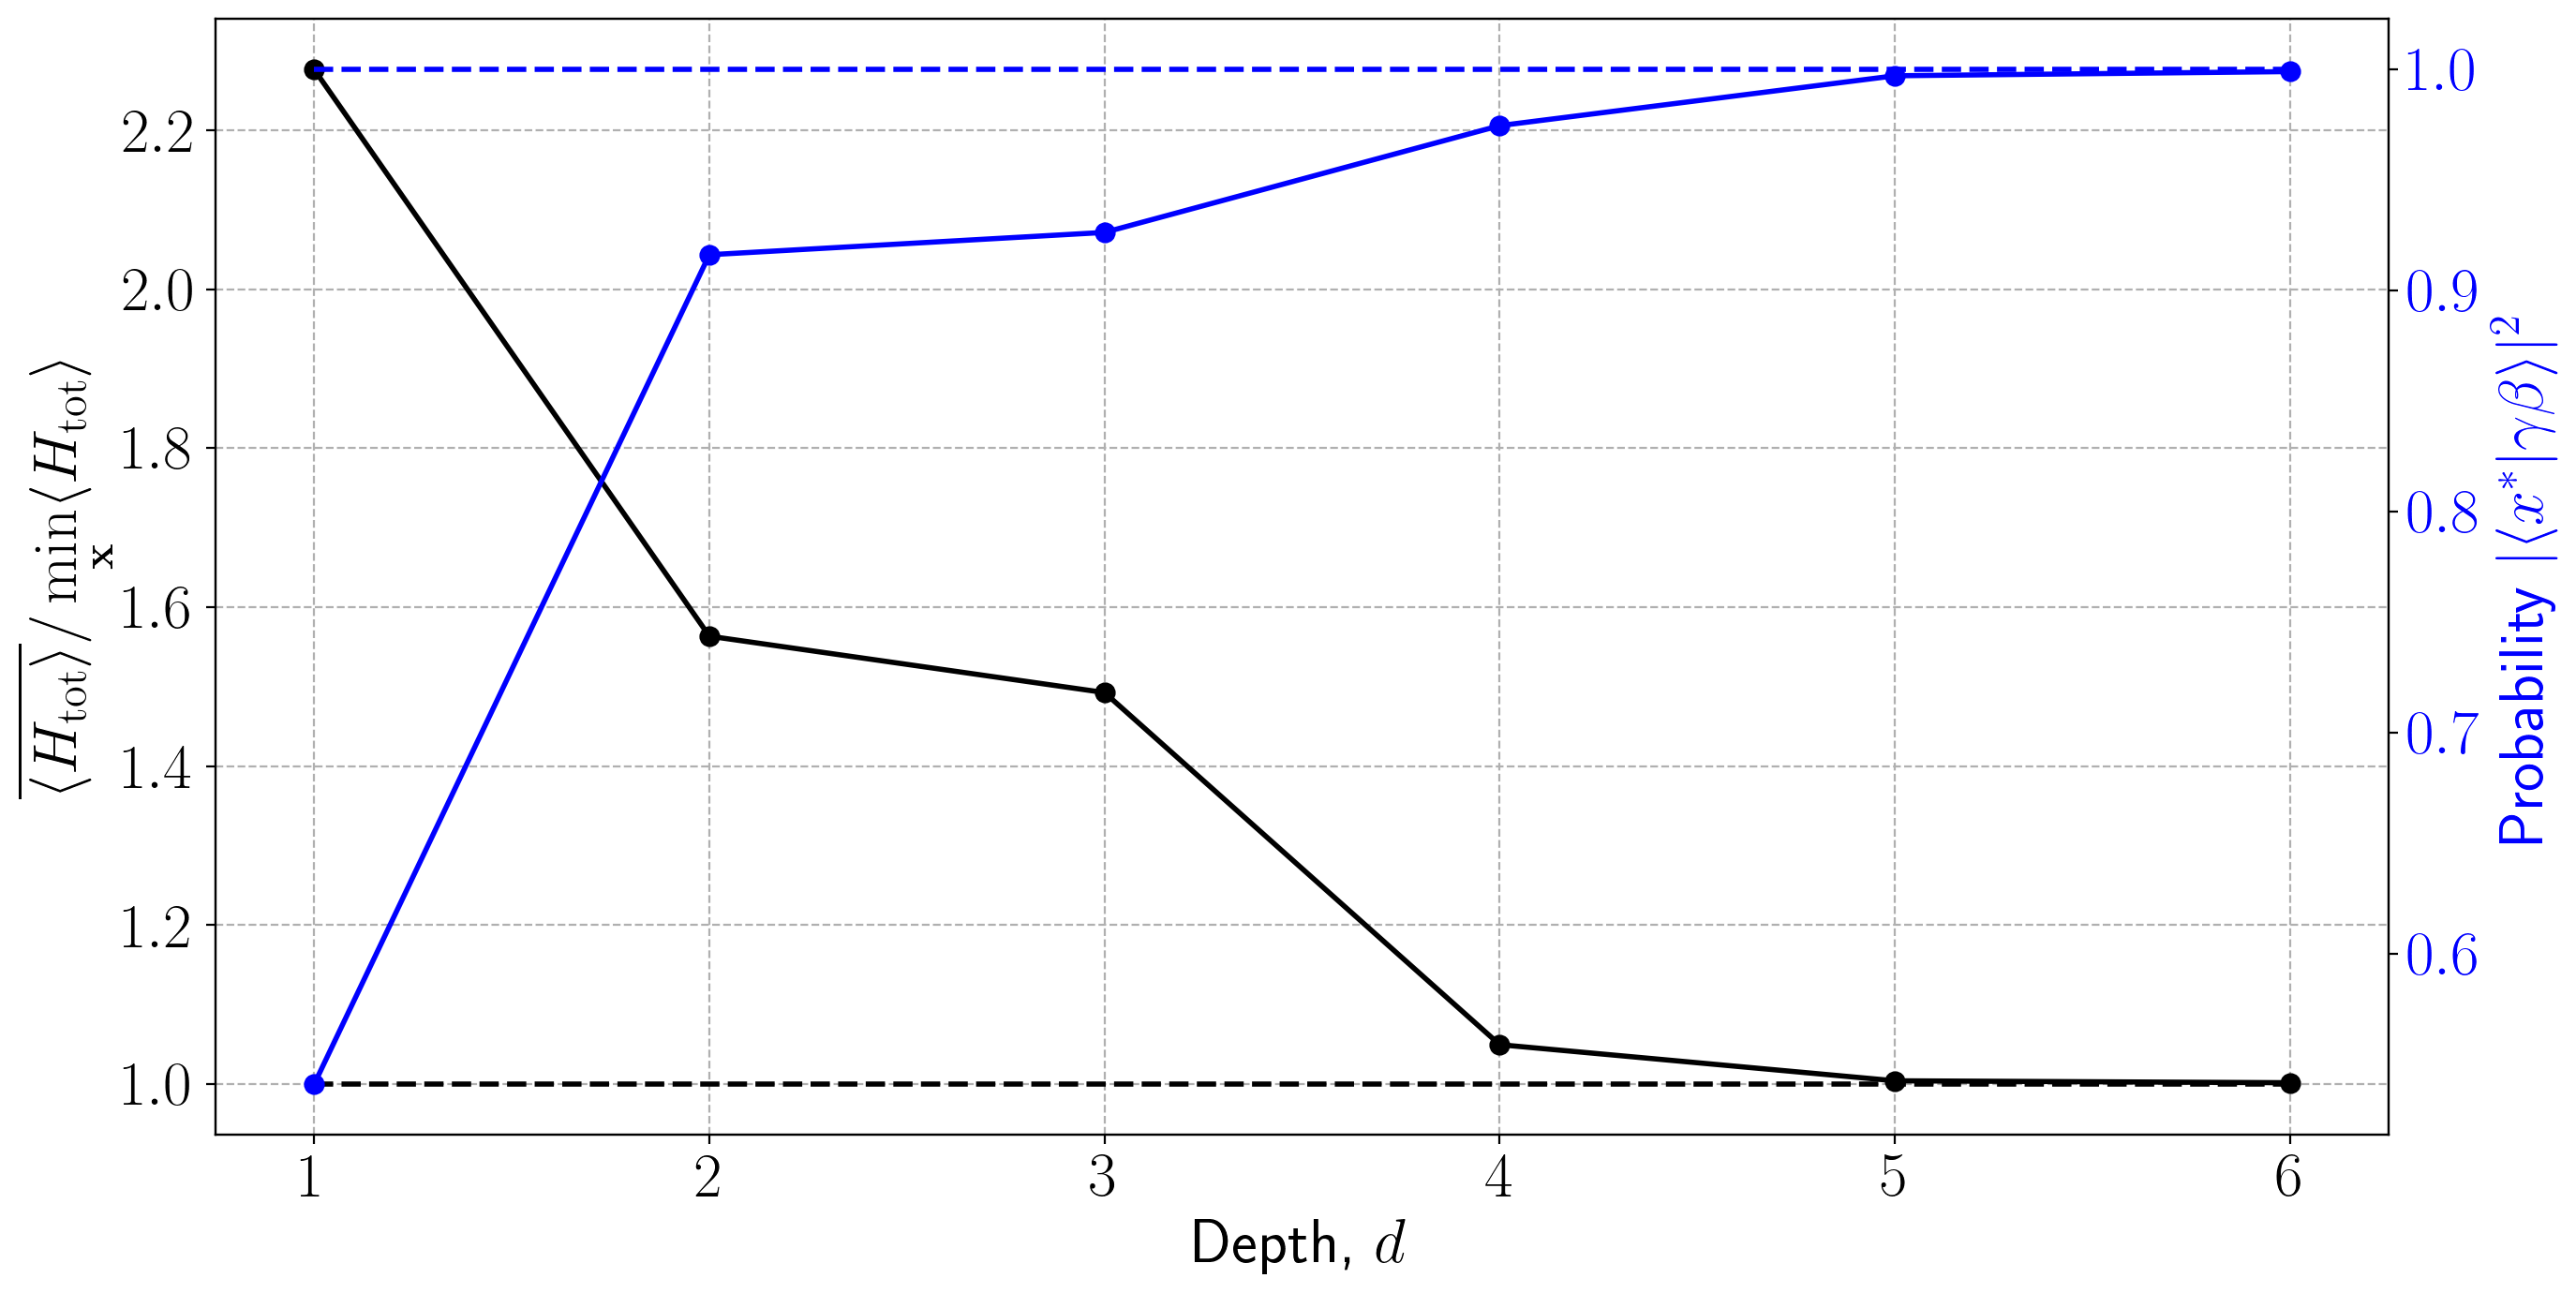

(array([0.54099941, 0.91620755, 0.9263069 , 0.97460071, 0.99715327,
        0.99904918]),
 array([-1.36581715, -0.938149  , -0.89559515, -0.62986699, -0.6026126 ,
        -0.60115071]))

In [18]:
qaoa3param.simulation_statistics(plot = True)

In [20]:
gammabetadeltas = qaoa3param.params

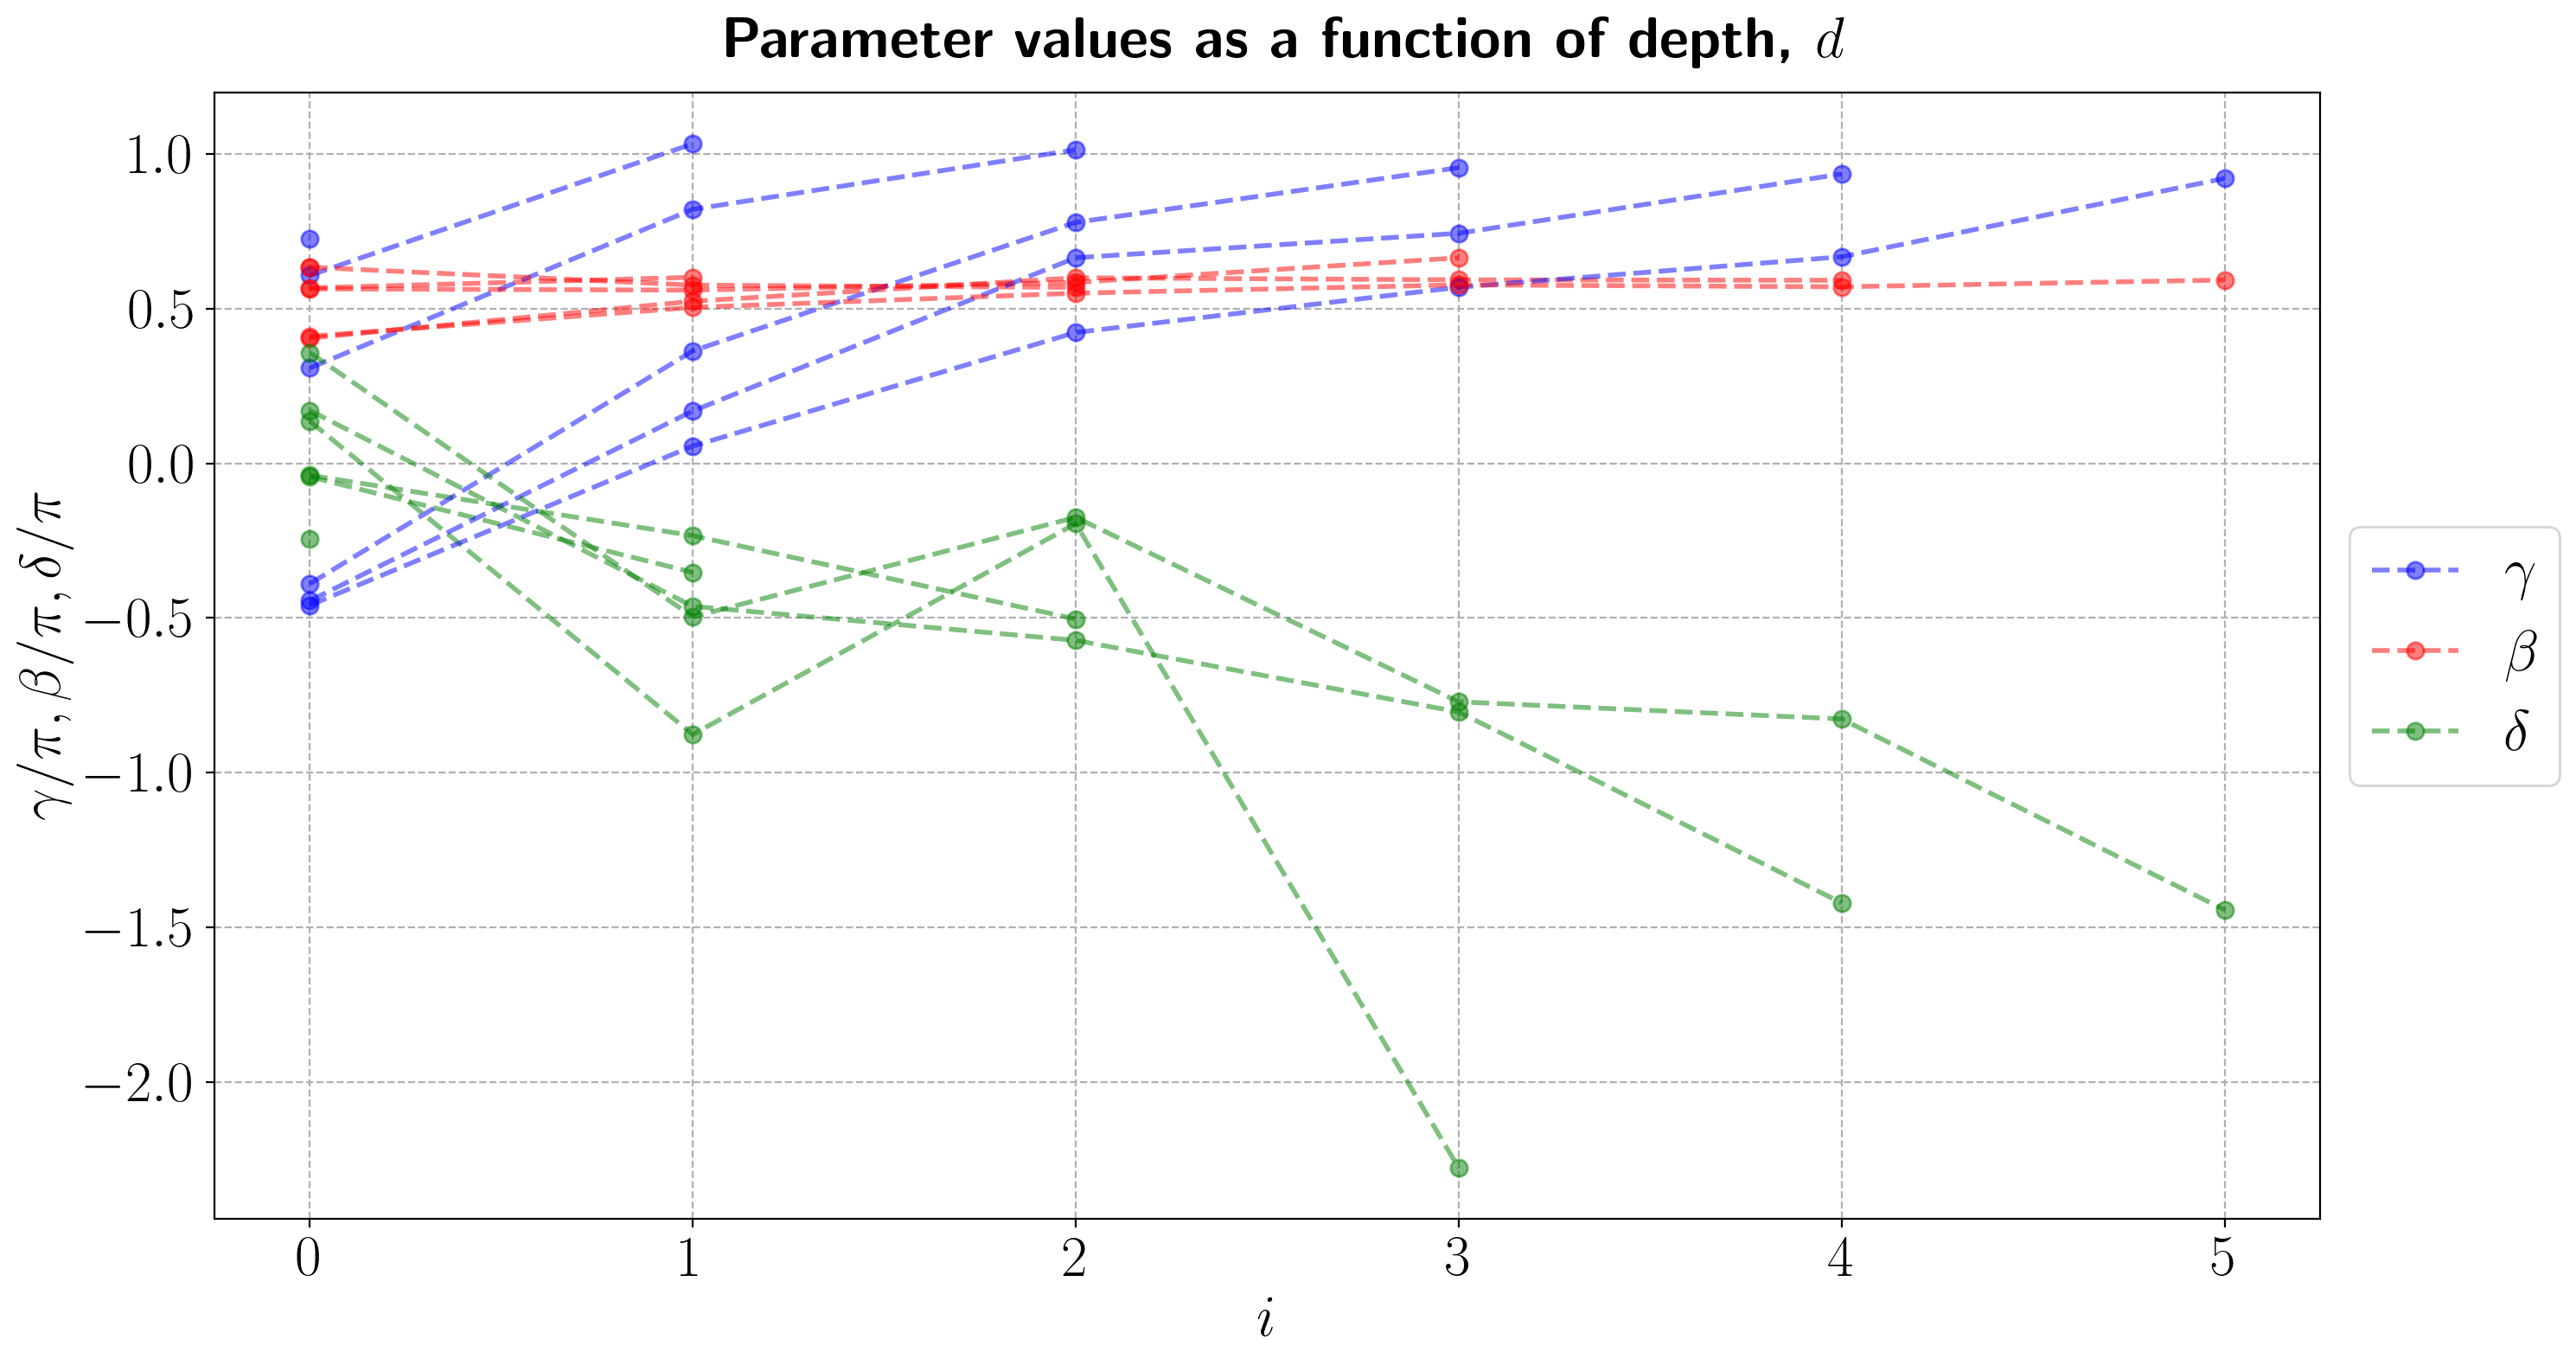

In [22]:
fig, ax  = plt.subplots(figsize = (15,8))

for i in range(max_depth - 1):

    ax.plot(gammabetadeltas[f'xL_d{i+1}'][::3]/np.pi, 
               ls = "--",alpha =0.5, marker = "o",
               color = "blue")
    ax.plot(gammabetadeltas[f'xL_d{i+1}'][1::3]/np.pi,
               ls = "--",alpha =0.5, marker = "o", 
               color = "red")
    ax.plot(gammabetadeltas[f'xL_d{i+1}'][2::3]/np.pi,
               ls = "--",alpha =0.5, marker = "o",
               color = "green")

ax.plot(gammabetadeltas[f'xL_d{max_depth}'][::3]/np.pi, 
           ls = "--",alpha =0.5, marker = "o",
           color = "blue",label=r"$\gamma$")
ax.plot(gammabetadeltas[f'xL_d{max_depth}'][1::3]/np.pi,
           ls = "--",alpha =0.5, marker = "o", 
           color = "red", label = r"$\beta$")
ax.plot(gammabetadeltas[f'xL_d{max_depth}'][2::3]/np.pi,
           ls = "--",alpha =0.5, marker = "o",
           color = "green", label = r"$\delta$")

ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\gamma/\pi, \beta /\pi, \delta/\pi$")

plt.suptitle(r"\textbf{Parameter values as a function of depth, $d$}")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(ls = "--")

plt.tight_layout()
#fig.savefig(f"../../imgs/params_{instances}_{flights}_{solutions}.pdf")